## Production Run All Centrality -- Fast Version

## Importing & Setting UP

In [3]:
# ================================
# eLoss-only notebook (pub styling)
# ================================
import numpy as np, matplotlib.pyplot as plt
import sys, os
from dataclasses import replace
sys.path.append("../eloss_code")

# --- imports & knobs ---
from particle import Particle
from glauber  import SystemSpec, OpticalGlauber
from coupling import alpha_s_provider
from cross_sections import SigmaPPTable, L_eff_minbias  # if you prefer Torch table, see below
import quenching_fast as QF

In [7]:
# energies & σ_nn
roots5, roots8 = 5023.0, 8160.0
sigma_nn_5, sigma_nn_8 = 67.6, 71.0
A = 208
device = "cuda"  # or "cpu"

# particles
P_charmonia = Particle(family="charmonia",  state="avg")
P_bottomonia = Particle(family="bottomonia", state="avg")

# pp table grid (densify 4–12 GeV to smooth R(pT) )
y_tab  = np.linspace(-5, 5, 41)
pt_tab = np.unique(np.concatenate([np.linspace(0,4,41), np.linspace(4,12,161), np.linspace(12,25,131)]))

# choose αs (constant for AP)
alpha_cst = alpha_s_provider(mode="constant", alpha0=0.5)

In [6]:
# --- 1) σ_pp tables (build once per species/energy)
Y_GRID = np.linspace(-5.5, 5.5, 241)
PT_GRID = np.linspace(0.0, 30.0, 301)
# Torch pp tables if torch is available (fast), else you can skip and the module uses P.d2sigma_pp directly
try:
    TAB_chi_5  = QF.TorchSigmaPPTable(P_charmonia, roots5, Y_GRID, PT_GRID, device=device)
    TAB_chi_8  = QF.TorchSigmaPPTable(P_charmonia, roots8, Y_GRID, PT_GRID, device=device)
    TAB_ups_5  = QF.TorchSigmaPPTable(P_bottomonia, roots5, Y_GRID, PT_GRID, device=device)
    TAB_ups_8  = QF.TorchSigmaPPTable(P_bottomonia, roots8, Y_GRID, PT_GRID, device=device)
except Exception:
    TAB_chi_5 = TAB_chi_8 = TAB_ups_5 = TAB_ups_8 = None  # falls back to NumPy path

# Glauber systems (for centrality & L_eff)
gl5 = OpticalGlauber(SystemSpec("pA", roots5, A=A, sigma_nn_mb=sigma_nn_5))
gl8 = OpticalGlauber(SystemSpec("pA", roots8, A=A, sigma_nn_mb=sigma_nn_8))
Lmb_5 = gl5.leff_minbias_pA() if hasattr(gl5, "leff_minbias_pA") else gl5.leff_minbias("pA")
Lmb_8 = gl8.leff_minbias_pA() if hasattr(gl8, "leff_minbias_pA") else gl8.leff_minbias("pA")

cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

Leff_5  = gl5.leff_bins_pA(cent_bins, method="optical")  # or "binomial"
Leff_8  = gl8.leff_bins_pA(cent_bins, method="optical")  # or "binomial"
print("L_eff (5 TeV pPb): ", Leff_5)
print("L_eff (8 TeV pPb): ", Leff_8)

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7724.42 mb, σ_tot^pA ≈ 1911.63 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb
L_eff (5 TeV pPb):  {'0-20%': 13.30462493265472, '20-40%': 10.811136886553728, '40-60%': 7.747887489470812, '60-80%': 4.705710625891892, '80-100%': 2.4437625515260213}
L_eff (8 TeV pPb):  {'0-20%': 13.304624932654724, '20-40%': 10.775229950676886, '40-60%': 7.652683082523533, '60-80%': 4.64752469601636, '80-100%': 2.4437634046948857}


In [16]:
# --- 5) BINNED curves vs y and vs pT at multiple centralities
cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
L_by_bin  = gl5.leff_bins_pA(cent_bins, method="optical")  # dict: "0-20%"→L_eff

In [17]:
import math
# ----- Centrality (Glauber-driven) ------------------------------------------
_MB_TO_FM2 = 0.1  # 1 mb = 0.1 fm^2

def _normalize_cent_bins(cent_edges_or_bins):
    arr = np.asarray(cent_edges_or_bins, dtype=float)
    if arr.ndim == 1:
        edges = np.unique(np.sort(arr))
        if edges.size < 2:
            raise ValueError("cent_edges must have ≥2 values, e.g. [0,20,40,60,80,100].")
        bins_list = [(float(edges[i]), float(edges[i+1])) for i in range(edges.size-1)]
    else:
        bins_list = [(float(a), float(b)) for (a, b) in cent_edges_or_bins]
        edges = np.unique(np.sort(np.array([v for ab in bins_list for v in ab], float)))
    labels  = [f"{int(a)}-{int(b)}%" for (a,b) in bins_list]
    centers = 0.5 * np.array([a + b for (a,b) in bins_list], float)
    return edges, bins_list, labels, centers

def _optical_bin_weight_pA(glauber, c0_percent: float, c1_percent: float, n_sub: int = 1200) -> float:
    bmin = float(glauber.b_from_percentile(c0_percent/100.0, kind="pA"))
    bmax = float(glauber.b_from_percentile(c1_percent/100.0, kind="pA"))
    if bmax <= bmin:
        return 0.0
    b_sub = np.linspace(bmin, bmax, n_sub)
    TpA_sub = np.interp(b_sub, np.asarray(glauber.b_grid, float), np.asarray(glauber.TpA_b, float))
    sigma_fm2 = float(glauber.spec.sigma_nn_mb) * _MB_TO_FM2
    pinel = 1.0 - np.exp(-sigma_fm2 * np.maximum(TpA_sub, 0.0))
    integrand = 2.0 * math.pi * b_sub * pinel
    numer_fm2 = float(np.trapezoid(integrand, b_sub))
    sigma_tot_fm2 = float(glauber.sigma_pA_tot_mb) * _MB_TO_FM2
    return numer_fm2 / max(sigma_tot_fm2, 1e-30)


In [21]:
for cen in cent_bins:
    print(_optical_bin_weight_pA(gl5,cen[0],cen[1]))

<generator object <genexpr> at 0x735c8024f2e0>
0.19431015701607157
0.19764255651767074
0.1982415862142685
0.19977309257656756
0.21035837391420628


In [8]:
QP5 = QF.QuenchParams(qhat0=0.075, lp_fm=1.5, LA_fm=Lmb_5, LB_fm=Lmb_5,
                     lambdaQCD=0.25, roots_GeV=roots5,
                     alpha_of_mu=alpha_cst, alpha_scale="mT",
                     use_hard_cronin=True, mapping="exp", device=device)

QP8 = replace(QP5, roots_GeV=roots8, LA_fm=Lmb_8, LB_fm=Lmb_8)

In [9]:
def make_edges(vmin, vmax, width):
    n = int(np.ceil((vmax - vmin)/width))
    return np.linspace(vmin, vmin + n*width, n+1)

# examples
Y_EDGES  = make_edges(-5.0, 5.0, 0.5)     # default dy=0.5
PT_EDGES = make_edges(0.0, 15.0, 2.5)   # default dpt=2.5 

# Three rapidity windows (edit here)
Y_THREE = [(-4.5,-3.0), (-1.5,0.5), (2.0,3.5)]
# One pT window for centrality plots (edit here)
PT_WIN  = (0.0, 10.0)

# For RpA(y): choose pT window
PT_FOR_Y = (0.0, 5.0)
# For RpA(pT): choose y windows (reuse Y_THREE by default)
Y_FOR_PT = Y_THREE


## $R_{pA}$ (Binned)

In [10]:
def _sort_bins(d):
    def key(lbl):
        s = str(lbl).replace('%','').replace(' ','').replace(',','-')
        a,b = s.split('-')[:2]
        return (int(a), int(b))
    items = list(d.items())
    items.sort(key=lambda kv: key(kv[0]))
    return items

In [11]:
# replace the try/except block that builds Torch tables with CPU tables:
TAB_chi_5 = SigmaPPTable(P_charmonia,  roots5, y_tab, pt_tab)
TAB_chi_8 = SigmaPPTable(P_charmonia,  roots8, y_tab, pt_tab)
TAB_ups_5 = SigmaPPTable(P_bottomonia, roots5, y_tab, pt_tab)
TAB_ups_8 = SigmaPPTable(P_bottomonia, roots8, y_tab, pt_tab)

In [12]:
def RpA_vs_y_allC(P, roots, QP_base, TAB, glauber, y_edges, pt_range,
                  title_tag="", weight="pp", Ny=18, Np=36):
    Leff = glauber.leff_bins_pA(cent_bins, method="optical")
    Leff["0-100%"] = (glauber.leff_minbias_pA()
                      if hasattr(glauber,"leff_minbias_pA") else glauber.leff_minbias("pA"))
    bins_sorted = _sort_bins(Leff)

    mids = 0.5*(y_edges[:-1]+y_edges[1:])
    fig, ax = plt.subplots(figsize=(7.2,4.0), dpi=130)
    cmap = plt.get_cmap("tab10")
    for i, (lab,L) in enumerate(bins_sorted):
        qpL = replace(QP_base, LA_fm=float(L))
        vals=[]
        for yl, yr in zip(y_edges[:-1], y_edges[1:]):
            Rbar = QF.nuclear_modification_binned(
                P, roots, qpL, (yl,yr), pt_range, TAB, kind="pA",
                Ny_bin=Ny, Npt_bin=Np,
                weight_kind=("pp" if weight=="pp" else "pA"),
                weight_ref_y=(0.0 if weight=="pp" else "local"),
                use_torch=True
            )
            vals.append(Rbar)
        ax.step(mids, np.array(vals), where="mid", lw=1.8, color=cmap(i),
                label=f"{lab}  (L={float(L):.2f} fm)")
    ax.axhline(1.0, ls=":", c="k", lw=1.0)
    ax.set(xlabel="y", ylabel=r"$\overline{R}_{pA}$",
           title=rf"{title_tag}  {pt_range[0]:.1f}<p_T<{pt_range[1]:.1f} GeV")
    ax.legend(ncol=2, frameon=False, fontsize=9)
    plt.tight_layout(); plt.show()

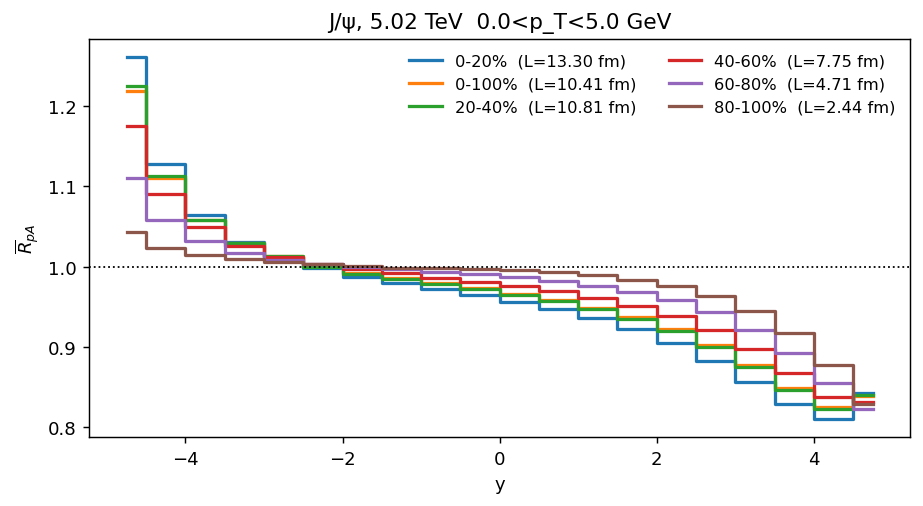

In [13]:
Y_EDGES = np.arange(-5.0, 5.0+0.25, 0.5)
RpA_vs_y_allC(P_charmonia, roots5, QP5, TAB_chi_5, gl5, Y_EDGES, PT_FOR_Y, title_tag="J/ψ, 5.02 TeV")
# RpA_vs_y_allC(P_charmonia, roots8, QP8, TAB_chi_8, gl8, Y_EDGES, PT_FOR_Y, title_tag="J/ψ, 8.16 TeV")

In [11]:
def RpA_vs_pT_panels(P, roots, QP_base, TAB, glauber, pt_edges, y_windows,
                     title_tag="", weight="pp", Ny=18, Np=36):
    Leff = glauber.leff_bins_pA(cent_bins, method="optical")
    Leff["0-100%"] = (glauber.leff_minbias_pA()
                      if hasattr(glauber,"leff_minbias_pA") else glauber.leff_minbias("pA"))
    bins_sorted = _sort_bins(Leff)

    for (yl,yr) in y_windows:
        mids = 0.5*(pt_edges[:-1]+pt_edges[1:])
        fig, ax = plt.subplots(figsize=(7.2,4.0), dpi=130)
        cmap = plt.get_cmap("tab10")
        for i,(lab,L) in enumerate(bins_sorted):
            qpL = replace(QP_base, LA_fm=float(L))
            vals=[]
            for pl, pr in zip(pt_edges[:-1], pt_edges[1:]):
                Rbar = QF.nuclear_modification_binned(
                    P, roots, qpL, (yl,yr), (pl,pr), TAB, kind="pA",
                    Ny_bin=Ny, Npt_bin=Np,
                    weight_kind=("pp" if weight=="pp" else "pA"),
                    weight_ref_y=(0.0 if weight=="pp" else "local"),
                    use_torch=True
                )
                vals.append(Rbar)
            ax.step(mids, np.array(vals), where="mid", lw=1.8, color=cmap(i),
                    label=f"{lab}  (L={float(L):.2f} fm)")
        ax.axhline(1.0, ls=":", c="k", lw=1.0)
        ax.set(xlabel=r"$p_T$ [GeV]", ylabel=r"$\overline{R}_{pA}$",
               title=rf"{title_tag}  {yl:.1f}<y<{yr:.1f}")
        ax.legend(ncol=2, frameon=False, fontsize=9)
        plt.tight_layout(); plt.show()

In [12]:
# PT_EDGES = np.arange(0.0, 20.0+1.0, 1.0)
# RpA_vs_pT_panels(P_charmonia, roots5, QP5, TAB_chi_5, gl5, PT_EDGES, Y_FOR_PT, title_tag="J/ψ, 5.02 TeV")

In [13]:
# RpA_vs_pT_panels(P_charmonia, roots8, QP8, TAB_chi_8, gl8, PT_EDGES, Y_FOR_PT, title_tag="J/ψ, 8.16 TeV")

## $R_{pA}$ (Binned + Band)

### Helpers

In [24]:
# knobs from your notebook
q0_pair = (0.05, 0.09)
cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
Y_THREE   = [(-4.5,-3.0), (-1.5,0.5), (2.0,3.5)]
PT_WIN    = (0.0, 10.0)
Y_EDGES   = np.arange(-5.0, 5.0+0.5, 0.5)
PT_EDGES  = np.arange(0.0, 20.0+1.0, 1.0)

In [33]:
# ---------- utilities (drop-in) ----------
import os, numpy as np, matplotlib.pyplot as plt
from dataclasses import replace

def _safe_energy_str(roots_GeV: float) -> str:
    return f"√s={roots_GeV/1000:.2f} TeV"  # avoids mathtext entirely

def _note(ax, text: str, loc="upper left", pad=3, fontsize=10):
    # unobtrusive, no LaTeX
    x, y = {"upper left":(0.02,0.98),"upper right":(0.98,0.98),
            "lower left":(0.02,0.02),"lower right":(0.98,0.02)}[loc]
    ax.text(x, y, text, ha=("right" if "right" in loc else "left"),
            va=("top" if "upper" in loc else "bottom"),
            transform=ax.transAxes, fontsize=fontsize)

def _write_band_csv(path, header, rows):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, np.array(rows, dtype=object), fmt="%s",
               header=",".join(header), comments="", delimiter=",")

def _band_from_curves(curves):
    """curves: list of arrays with identical shape -> (lo, mid, hi) with mid centered."""
    M = np.vstack(curves)             # [n_q0, n_bins]
    lo = M.min(axis=0)
    hi = M.max(axis=0)
    mid = 0.5*(lo + hi)               # geometric center of the band
    return lo, mid, hi

def _edges_from_cent_bins(cent_bins):
    # accepts [(0,20), (20,40), ...] or edges array-like
    if np.ndim(cent_bins) == 1 and len(cent_bins) and not hasattr(cent_bins[0], "__len__"):
        return np.asarray(cent_bins, float)
    edges = [cent_bins[0][0]] + [b for (_, b) in cent_bins]
    return np.asarray(edges, float)

def _stairs_xy(edges, y_vals, where="post"):
    """Step x,y for a piecewise-constant y over edges. y_vals: len = len(edges)-1."""
    x = np.repeat(edges, 2)[1:-1]
    y = np.repeat(y_vals, 2)
    if where == "mid":
        # keep centers but plot as steps anyway
        pass
    return x, y

def _stairs_fill_between(ax, edges, lo, hi, **kw):
    x = np.repeat(edges, 2)[1:-1]
    ylo = np.repeat(lo, 2)
    yhi = np.repeat(hi, 2)
    ax.fill_between(x, ylo, yhi, **kw)

def _style_axes(ax, show_frame=True):
    ax.grid(False)
    if show_frame:
        for s in ax.spines.values():
            s.set_visible(True)
    ax.tick_params(direction="in", top=True, right=True)


### vs Centrality

In [35]:
def rpa_band_vs_centrality(
    P, roots, QP_base, TABLE, glauber,
    cent_bins, y_range, pt_range,
    q0_pair=(0.05, 0.09),
    kind="pA",
    Ny_bin=18, Npt_bin=36,
    weight_kind="pA",
    weight_ref_y=0.0,
    device_tag="",
    save_csv=None,
    ax=None, label=None, color=None, ls="-", lw=2.0,
    ylims=None, step=True,
):
    # 1) per-q0 curves on identical binning/weights
    curves, mb_avg_vals = [], []
    for q0 in q0_pair:
        qp = replace(QP_base, qhat0=float(q0))
        out = QF.nuclear_modification_centrality_binned(
            P, roots, qp, TABLE, glauber, cent_bins,
            y_range, pt_range, kind=kind,
            Ny_bin=Ny_bin, Npt_bin=Npt_bin,
            weight_kind=weight_kind, weight_ref_y=weight_ref_y,
            use_torch=True
        )
        curves.append(out["R"])
        mb_avg_vals.append(out["R_minbias"])
        centers, labels, Leff, w = out["centers"], out["labels"], out["Leff"], out["weights"]

    lo, mid, hi = _band_from_curves(curves)

    # 2) min-bias via single L_eff(min-bias) (dashed horizontal bands)
    Lmb = (glauber.leff_minbias_pA() if hasattr(glauber,"leff_minbias_pA")
           else glauber.leff_minbias("pA"))
    mb_Leff = []
    for q0 in q0_pair:
        qpL = replace(QP_base, qhat0=float(q0), LA_fm=float(Lmb), LB_fm=float(Lmb))
        mb_Leff.append(QF.nuclear_modification_binned(
            P, roots, qpL, y_range, pt_range, TABLE, kind=kind,
            Ny_bin=Ny_bin, Npt_bin=Npt_bin,
            weight_kind=weight_kind, weight_ref_y=weight_ref_y, use_torch=True))
    mb_avg_lo, mb_avg_hi = min(mb_avg_vals), max(mb_avg_vals)
    mb_L_lo,   mb_L_hi   = min(mb_Leff),    max(mb_Leff)

    # 3) plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.8,3.8), dpi=130)
    _style_axes(ax)

    edges = _edges_from_cent_bins(cent_bins)
    _stairs_fill_between(ax, edges, lo, hi, alpha=0.25, color=color)

    if step:
        xm, ym = _stairs_xy(edges, mid)
        ax.plot(xm, ym, ls=ls, lw=lw, color=color, label=label or _safe_energy_str(roots))
    else:
        ax.plot(centers, mid, ls=ls, lw=lw, color=color, label=label or _safe_energy_str(roots))

    # dashed horizontal min-bias bands (avg-over-bins and L_eff variants)
    ax.hlines([mb_avg_lo, mb_avg_hi], edges[0], edges[-1], colors=color, linestyles="--", alpha=0.25)
    ax.hlines([mb_L_lo,   mb_L_hi],   edges[0], edges[-1], colors=color, linestyles="--", alpha=0.25)

    ax.axhline(1.0, ls=":", c="k", lw=1.0)
    ax.set_xlim(edges[0], edges[-1])
    if ylims: ax.set_ylim(*ylims)
    ax.set_xlabel("centrality [%]")
    ax.set_ylabel(r"$R_{pA}$")
    _note(ax, f"{P.family} {P.state} | {_safe_energy_str(roots)} | "
              f"{y_range[0]:.1f}<y<{y_range[1]:.1f}, {pt_range[0]:.1f}–{pt_range[1]:.1f} GeV")

    if label is not None:
        ax.legend(ncol=2, frameon=False, fontsize=9)

    # 4) CSV
    if save_csv:
        rows = [[xl, xr, rl, 0.5*(rl+rh), rh] for (xl,xr,rl,rh) in zip(edges[:-1], edges[1:], lo, hi)]
        rows += [["MB(avg-bins)","", mb_avg_lo, 0.5*(mb_avg_lo+mb_avg_hi), mb_avg_hi],
                 ["MB(L_eff)","",   mb_L_lo,   0.5*(mb_L_lo+mb_L_hi),     mb_L_hi]]
        _write_band_csv(save_csv, ["cent_min","cent_max","R_lo","R_mid","R_hi"], rows)

    return dict(centers=centers, edges=edges, labels=labels, Leff=Leff, weights=w,
                band_lo=lo, band_hi=hi, band_mid=mid,
                mb_avg=(mb_avg_lo, 0.5*(mb_avg_lo+mb_avg_hi), mb_avg_hi),
                mb_Leff=(mb_L_lo,  0.5*(mb_L_lo+mb_L_hi),    mb_L_hi))

In [31]:
# # -- Figure A: RpA vs centrality (3 rapidity windows; 8 TeV solid, 5 TeV dashed)
# fig, axs = plt.subplots(1, 3, figsize=(12,3.6), dpi=130, sharey=True)
# for ax, ywin in zip(axs, Y_THREE):
#     rpa_band_vs_centrality(P_bottomonia, roots8, QP8, TAB_ups_8, gl8,
#                            cent_bins, y_range=ywin, pt_range=PT_WIN,
#                            q0_pair=q0_pair, weight_kind="pA",
#                            label=_safe_energy_str(roots8), color="C0", ls="-", ax=ax, step=True)
#     rpa_band_vs_centrality(P_bottomonia, roots5, QP5, TAB_ups_5, gl5,
#                            cent_bins, y_range=ywin, pt_range=PT_WIN,
#                            q0_pair=q0_pair, weight_kind="pA",
#                            label=_safe_energy_str(roots5), color="C3", ls="--", ax=ax, step=True)
# axs[0].legend(ncol=2, frameon=False, fontsize=9)
# plt.tight_layout(); plt.show()

In [ ]:
# -- Figure A: RpA vs centrality (3 rapidity windows; 8 TeV solid, 5 TeV dashed)
fig, axs = plt.subplots(1, 3, figsize=(12,3.6), dpi=130, sharey=True)

for ax, ywin in zip(axs, Y_THREE):
    _style_axes(ax, show_frame=True)   # frame on all sides, no grid

    # 8.16 TeV (solid blue)
    rpa_band_vs_centrality(
        P_charmonia, roots8, QP8, TAB_chi_8, gl8,
        cent_bins, y_range=ywin, pt_range=PT_WIN,
        q0_pair=q0_pair, weight_kind="pA",
        label=_safe_energy_str(roots8), color="C0", ls="-", ax=ax, step=True
    )

    # 5.02 TeV (dashed red)
    rpa_band_vs_centrality(
        P_charmonia, roots5, QP5, TAB_chi_5, gl5,
        cent_bins, y_range=ywin, pt_range=PT_WIN,
        q0_pair=q0_pair, weight_kind="pA",
        label=_safe_energy_str(roots5), color="C3", ls="--", ax=ax, step=True
    )

# ---- single clean legend for both energies (no repeats)
# grab handles/labels from the first panel, then uniquify while preserving order
h, l = axs[0].get_legend_handles_labels()
seen, H, L = set(), [], []
for hi, li in zip(h, l):
    if li not in seen and li.strip():
        H.append(hi); L.append(li); seen.add(li)

# put the shared legend below all axes; tighten layout above it
fig.legend(H, L, ncol=2, frameon=False, fontsize=9, loc="lower center")
plt.tight_layout(rect=[0,0.08,1,1])   # leave space at bottom for legend
plt.show()

### vs Rapidity

In [21]:
def rpa_band_vs_y_for_bin(P, roots, QP_base, TABLE, L_eff,
                          y_edges, pt_range, q0_pair=(0.05,0.09),
                          Ny_bin=18, Npt_bin=36, weight_kind="pA",
                          weight_ref_y=0.0, step=True):
    curves=[]
    for q0 in q0_pair:
        qpL = replace(QP_base, qhat0=float(q0), LA_fm=float(L_eff))
        vals=[]
        for yl, yr in zip(y_edges[:-1], y_edges[1:]):
            vals.append(QF.nuclear_modification_binned(
                P, roots, qpL, (yl,yr), pt_range, TABLE, kind="pA",
                Ny_bin=Ny_bin, Npt_bin=Npt_bin,
                weight_kind=weight_kind, weight_ref_y=weight_ref_y, use_torch=True))
        curves.append(np.array(vals))
    lo, mid, hi = _band_from_curves(curves)
    xm = np.repeat(y_edges, 2)[1:-1]
    return (xm if step else 0.5*(y_edges[:-1]+y_edges[1:])), \
           (np.repeat(lo,2) if step else lo), \
           (np.repeat(mid,2) if step else mid), \
           (np.repeat(hi,2) if step else hi)

def plot_rpa_band_vs_y_grid(P, roots5, roots8, QP5, QP8, TAB5, TAB8, glauber,
                            cent_bins, y_edges, pt_range, q0_pair=(0.05,0.09),
                            save_dir_csv=None, step=True):
    meta = QF.nuclear_modification_centrality_binned(
        P, roots8, QP8, TAB8, glauber, cent_bins, y_range=(0,0), pt_range=(0,0))
    labels, Leff, w = meta["labels"], meta["Leff"], meta["weights"]
    ylab = r"$\overline{R}_{pA}$"
    xm = np.repeat(y_edges, 2)[1:-1]; ym = 0.5*(y_edges[:-1]+y_edges[1:])

    nC = len(labels)
    ncols = 3
    nrows = (nC + 1 + ncols - 1)//ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.4*nrows), dpi=130, sharey=True)
    axs = axs.ravel()

    # per centrality
    for i,(lbl,L) in enumerate(zip(labels, Leff)):
        ax = axs[i]; _style_axes(ax)
        x, lo8, mid8, hi8 = rpa_band_vs_y_for_bin(P, roots8, QP8, TAB8, L, y_edges, pt_range,
                                                  q0_pair=q0_pair, step=step)
        ax.fill_between(x, lo8, hi8, alpha=0.25, color="C0")
        ax.plot(x, mid8, lw=2.0, color="C0", label=_safe_energy_str(roots8))
        x, lo5, mid5, hi5 = rpa_band_vs_y_for_bin(P, roots5, QP5, TAB5, L, y_edges, pt_range,
                                                  q0_pair=q0_pair, step=step)
        ax.fill_between(x, lo5, hi5, alpha=0.25, color="C3")
        ax.plot(x, mid5, lw=2.0, ls="--", color="C3", label=_safe_energy_str(roots5))
        ax.axhline(1.0, ls=":", c="k", lw=1.0)
        ax.set_xlabel("y"); ax.set_ylabel(ylab)
        _note(ax, f"{lbl} (L={L:.2f} fm) | {pt_range[0]:.0f}–{pt_range[1]:.0f} GeV")
        if save_dir_csv:
            os.makedirs(save_dir_csv, exist_ok=True)
            _write_band_csv(os.path.join(save_dir_csv, f"{P.family}_y_{lbl.replace('%','pct')}_8TeV.csv"),
                            ["y_min","y_max","R_lo","R_mid","R_hi"],
                            [[yl,yr,l,m,h] for (yl,yr,l,m,h) in zip(y_edges[:-1],y_edges[1:],lo8[::2],mid8[::2],hi8[::2])])
            _write_band_csv(os.path.join(save_dir_csv, f"{P.family}_y_{lbl.replace('%','pct')}_5TeV.csv"),
                            ["y_min","y_max","R_lo","R_mid","R_hi"],
                            [[yl,yr,l,m,h] for (yl,yr,l,m,h) in zip(y_edges[:-1],y_edges[1:],lo5[::2],mid5[::2],hi5[::2])])

    # min-bias panel
    ax = axs[len(labels)]; _style_axes(ax)
    curves8=[]; curves5=[]
    for q0 in q0_pair:
        qp8 = replace(QP8, qhat0=float(q0)); qp5 = replace(QP5, qhat0=float(q0))
        vals8=[]; vals5=[]
        for yl, yr in zip(y_edges[:-1], y_edges[1:]):
            r8=[]; r5=[]
            for L in Leff:
                r8.append(QF.nuclear_modification_binned(P, roots8, replace(qp8, LA_fm=float(L)),
                                                         (yl,yr), pt_range, TAB8, kind="pA",
                                                         Ny_bin=18, Npt_bin=36, weight_kind="pA", weight_ref_y=0.0))
                r5.append(QF.nuclear_modification_binned(P, roots5, replace(qp5, LA_fm=float(L)),
                                                         (yl,yr), pt_range, TAB5, kind="pA",
                                                         Ny_bin=18, Npt_bin=36, weight_kind="pA", weight_ref_y=0.0))
            vals8.append(np.sum(w*np.array(r8)))
            vals5.append(np.sum(w*np.array(r5)))
        curves8.append(np.array(vals8)); curves5.append(np.array(vals5))
    lo8, mid8, hi8 = _band_from_curves(curves8)
    lo5, mid5, hi5 = _band_from_curves(curves5)
    if step:
        ax.fill_between(xm, np.repeat(lo8,2), np.repeat(hi8,2), alpha=0.25, color="C0")
        ax.plot(xm, np.repeat(mid8,2), lw=2.0, color="C0", label=f"min-bias {_safe_energy_str(roots8)}")
        ax.fill_between(xm, np.repeat(lo5,2), np.repeat(hi5,2), alpha=0.25, color="C3")
        ax.plot(xm, np.repeat(mid5,2), lw=2.0, ls="--", color="C3", label=f"min-bias {_safe_energy_str(roots5)}")
    else:
        ax.fill_between(ym, lo8, hi8, alpha=0.25, color="C0")
        ax.plot(ym, mid8, lw=2.0, color="C0", label=f"min-bias {_safe_energy_str(roots8)}")
        ax.fill_between(ym, lo5, hi5, alpha=0.25, color="C3")
        ax.plot(ym, mid5, lw=2.0, ls="--", color="C3", label=f"min-bias {_safe_energy_str(roots5)}")
    ax.axhline(1.0, ls=":", c="k", lw=1.0)
    ax.set_xlabel("y"); ax.set_ylabel(ylab)
    _note(ax, f"min-bias | {pt_range[0]:.0f}–{pt_range[1]:.0f} GeV")
    axs[0].legend(ncol=2, frameon=False, fontsize=9)
    plt.tight_layout(); plt.show()

In [ ]:
# # -- Figure B: RpA vs y (grid: each centrality + min-bias)
# plot_rpa_band_vs_y_grid(P_bottomonia, roots5, roots8, QP5, QP8,
#                         TAB_ups_5, TAB_ups_8, gl8,
#                         cent_bins, Y_EDGES, PT_WIN, q0_pair=q0_pair,
#                         save_dir_csv="out/csv/y", step=True)

In [ ]:
# -- Figure B: RpA vs y (grid: each centrality + min-bias)
plot_rpa_band_vs_y_grid(P_charmonia, roots5, roots8, QP5, QP8,
                        TAB_chi_5, TAB_chi_8, gl8,
                        cent_bins, Y_EDGES, PT_WIN, q0_pair=q0_pair,
                        save_dir_csv="out/csv/y", step=True)

### vs $p_T$

In [22]:
def rpa_band_vs_pT_for_bin(P, roots, QP_base, TABLE, L_eff,
                           pt_edges, y_range, q0_pair=(0.05,0.09),
                           Ny_bin=18, Npt_bin=36, weight_kind="pA",
                           weight_ref_y=0.0, step=True):
    curves=[]
    for q0 in q0_pair:
        qpL = replace(QP_base, qhat0=float(q0), LA_fm=float(L_eff))
        vals=[]
        for pl, pr in zip(pt_edges[:-1], pt_edges[1:]):
            vals.append(QF.nuclear_modification_binned(
                P, roots, qpL, y_range, (pl,pr), TABLE, kind="pA",
                Ny_bin=Ny_bin, Npt_bin=Npt_bin,
                weight_kind=weight_kind, weight_ref_y=weight_ref_y, use_torch=True))
        curves.append(np.array(vals))
    lo, mid, hi = _band_from_curves(curves)
    xm = np.repeat(pt_edges, 2)[1:-1]
    return (xm if step else 0.5*(pt_edges[:-1]+pt_edges[1:])), \
           (np.repeat(lo,2) if step else lo), \
           (np.repeat(mid,2) if step else mid), \
           (np.repeat(hi,2) if step else hi)

def plot_rpa_band_vs_pT_grid(P, roots5, roots8, QP5, QP8, TAB5, TAB8, glauber,
                             cent_bins, pt_edges, y_window, q0_pair=(0.05,0.09),
                             save_dir_csv=None, step=True):
    meta = QF.nuclear_modification_centrality_binned(
        P, roots8, QP8, TAB8, glauber, cent_bins, y_range=(0,0), pt_range=(0,0))
    labels, Leff, w = meta["labels"], meta["Leff"], meta["weights"]
    ylab = r"$\overline{R}_{pA}$"
    xm = np.repeat(pt_edges, 2)[1:-1]; pm = 0.5*(pt_edges[:-1]+pt_edges[1:])

    nC = len(labels)
    ncols = 3
    nrows = (nC + 1 + ncols - 1)//ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.4*nrows), dpi=130, sharey=True)
    axs = axs.ravel()

    # per centrality
    for i,(lbl,L) in enumerate(zip(labels, Leff)):
        ax = axs[i]; _style_axes(ax)
        x, lo8, mid8, hi8 = rpa_band_vs_pT_for_bin(P, roots8, QP8, TAB8, L, pt_edges, y_window,
                                                   q0_pair=q0_pair, step=step)
        ax.fill_between(x, lo8, hi8, alpha=0.25, color="C0")
        ax.plot(x, mid8, lw=2.0, color="C0", label=_safe_energy_str(roots8))
        x, lo5, mid5, hi5 = rpa_band_vs_pT_for_bin(P, roots5, QP5, TAB5, L, pt_edges, y_window,
                                                   q0_pair=q0_pair, step=step)
        ax.fill_between(x, lo5, hi5, alpha=0.25, color="C3")
        ax.plot(x, mid5, lw=2.0, ls="--", color="C3", label=_safe_energy_str(roots5))
        ax.axhline(1.0, ls=":", c="k", lw=1.0)
        ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(ylab)
        _note(ax, f"{lbl} (L={L:.2f} fm) | {y_window[0]:.1f}<y<{y_window[1]:.1f}")
        if save_dir_csv:
            os.makedirs(save_dir_csv, exist_ok=True)
            _write_band_csv(os.path.join(save_dir_csv, f"{P.family}_pT_{lbl.replace('%','pct')}_8TeV.csv"),
                            ["pT_min","pT_max","R_lo","R_mid","R_hi"],
                            [[pl,pr,l,m,h] for (pl,pr,l,m,h) in zip(pt_edges[:-1],pt_edges[1:],lo8[::2],mid8[::2],hi8[::2])])
            _write_band_csv(os.path.join(save_dir_csv, f"{P.family}_pT_{lbl.replace('%','pct')}_5TeV.csv"),
                            ["pT_min","pT_max","R_lo","R_mid","R_hi"],
                            [[pl,pr,l,m,h] for (pl,pr,l,m,h) in zip(pt_edges[:-1],pt_edges[1:],lo5[::2],mid5[::2],hi5[::2])])

    # min-bias panel
    ax = axs[len(labels)]; _style_axes(ax)
    curves8=[]; curves5=[]
    for q0 in q0_pair:
        qp8 = replace(QP8, qhat0=float(q0)); qp5 = replace(QP5, qhat0=float(q0))
        vals8=[]; vals5=[]
        for pl, pr in zip(pt_edges[:-1], pt_edges[1:]):
            r8=[]; r5=[]
            for L in Leff:
                r8.append(QF.nuclear_modification_binned(P, roots8, replace(qp8, LA_fm=float(L)),
                                                         y_window, (pl,pr), TAB8, kind="pA",
                                                         Ny_bin=18, Npt_bin=36, weight_kind="pA", weight_ref_y=0.0))
                r5.append(QF.nuclear_modification_binned(P, roots5, replace(qp5, LA_fm=float(L)),
                                                         y_window, (pl,pr), TAB5, kind="pA",
                                                         Ny_bin=18, Npt_bin=36, weight_kind="pA", weight_ref_y=0.0))
            vals8.append(np.sum(w*np.array(r8)))
            vals5.append(np.sum(w*np.array(r5)))
        curves8.append(np.array(vals8)); curves5.append(np.array(vals5))
    lo8, mid8, hi8 = _band_from_curves(curves8)
    lo5, mid5, hi5 = _band_from_curves(curves5)
    if step:
        ax.fill_between(xm, np.repeat(lo8,2), np.repeat(hi8,2), alpha=0.25, color="C0")
        ax.plot(xm, np.repeat(mid8,2), lw=2.0, color="C0", label=f"min-bias {_safe_energy_str(roots8)}")
        ax.fill_between(xm, np.repeat(lo5,2), np.repeat(hi5,2), alpha=0.25, color="C3")
        ax.plot(xm, np.repeat(mid5,2), lw=2.0, ls="--", color="C3", label=f"min-bias {_safe_energy_str(roots5)}")
    else:
        ax.fill_between(pm, lo8, hi8, alpha=0.25, color="C0")
        ax.plot(pm, mid8, lw=2.0, color="C0", label=f"min-bias {_safe_energy_str(roots8)}")
        ax.fill_between(pm, lo5, hi5, alpha=0.25, color="C3")
        ax.plot(pm, mid5, lw=2.0, ls="--", color="C3", label=f"min-bias {_safe_energy_str(roots5)}")
    ax.axhline(1.0, ls=":", c="k", lw=1.0)
    ax.set_xlabel(r"$p_T$ [GeV]"); ax.set_ylabel(ylab)
    _note(ax, f"min-bias | {y_window[0]:.1f}<y<{y_window[1]:.1f}")
    axs[0].legend(ncol=2, frameon=False, fontsize=9)
    plt.tight_layout(); plt.show()

In [ ]:
# # -- Figure C: RpA vs pT (repeat for your three y windows)
# for ywin in Y_THREE:
#     plot_rpa_band_vs_pT_grid(P_bottomonia, roots5, roots8, QP5, QP8,
#                              TAB_ups_5, TAB_ups_8, gl8,
#                              cent_bins, PT_EDGES, ywin, q0_pair=q0_pair,
#                              save_dir_csv=f"out/csv/pT_y{ywin[0]}_{ywin[1]}", step=True)

In [ ]:
# -- Figure C: RpA vs pT (repeat for your three y windows)
for ywin in Y_THREE:
    plot_rpa_band_vs_pT_grid(P_charmonia, roots5, roots8, QP5, QP8,
                             TAB_chi_5, TAB_chi_8, gl8,
                             cent_bins, PT_EDGES, ywin, q0_pair=q0_pair,
                             save_dir_csv=f"out/csv/pT_y{ywin[0]}_{ywin[1]}", step=True)